### Imports

In [1]:
import fdasrsf
from statistics import mode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from numpy import tile, eye, arccos, zeros, sin, arange, linspace, empty
from copy import deepcopy
import fdasrsf.geodesic as gd
import os
from tqdm import notebook as tqdm
import re
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import fdasrsf.curve_functions as cf
from sklearn.metrics.cluster import adjusted_rand_score

### Data

In [118]:
table = pd.read_csv("shells_sample_index.csv")
table_meta = pd.read_csv("shells_metadata.csv")
train_names = list(table[table["Test_Train"]=="train"]["Name"])
test_names = list(table[table["Test_Train"]=="test"]["Name"])
all_dists = pd.read_csv("EigenshapeDists_unitlength_proc_shells_dim16_2.csv")
all_dists = all_dists.set_index('Name')

title = "Shells_EShape_UL_Proc_16D_k4"


### Shell Coordinates

In [119]:
pth = "Shells_Coords_UnitLength_Proc.csv"
table_2 = pd.read_csv(pth,header=None)

all_points = []
n = len(table_2)
for j in range(0,n):
    coords = list(table_2.T[j])
    x = []
    y = []
    for i in range(0,len(coords)):
        if i%2 == 0:
            x.append(coords[i])
        else:
            y.append(coords[i])

    x.append(x[0])
    y.append(y[-1])
    
    rng = abs(max(y)-min(y))
    x = list(np.array(x)/rng)
    y = list(np.array(y)/rng)
    
    F = np.column_stack((x,y)).T    
    all_points.append(F)

### KNN Classification

In [120]:
# We'll make note of the family, genus and specie accuracy of the results in the following dictionaries.
# Here, we assume that we will test various values for K, up to K=8.

family_stats = {}
genus_stats = {}
specie_stats = {}

for shell in test_names:
    family = list(table[table["Name"]==shell]["Genus"])[0]
    family_stats.update({family:{"total":0,"K1":0,"K3":0,"K4":0,"K5":0,"K6":0,"K7":0,"K8":0}})
    genus = list(table[table["Name"]==shell]["Specie"])[0]
    genus_stats.update({genus:{"total":0,"K1":0,"K3":0,"K4":0,"K5":0,"K6":0,"K7":0,"K8":0}})
    specie = list(table[table["Name"]==shell]["Sub-specie"])[0]
    specie_stats.update({specie:{"total":0,"K1":0,"K3":0,"K4":0,"K5":0,"K6":0,"K7":0,"K8":0}})
    
for shell in test_names:
    family = list(table[table["Name"]==shell]["Genus"])[0]
    tot = int(family_stats[family]["total"])
    family_stats[family]["total"] = tot+1
    genus = list(table[table["Name"]==shell]["Specie"])[0]
    tot = int(genus_stats[genus]["total"])
    genus_stats[genus]["total"] = tot+1
    specie = list(table[table["Name"]==shell]["Sub-specie"])[0]
    tot = int(specie_stats[specie]["total"])
    specie_stats[specie]["total"] = tot+1
    
    
unq_family = list(np.unique(list(table["Genus"])))
unq_genus = list(np.unique(list(table["Specie"])))
unq_specie = list(np.unique(list(table["Sub-specie"])))

unq_names_fm = []
for shell in unq_family:
    unq_names_fm.append(list(table_meta[table_meta["family_number"] == shell]["family"])[0])
    
unq_names_gn = []
for shell in unq_genus:
    unq_names_gn.append(list(table_meta[table_meta["genus_number"] == shell]["genus"])[0])
    
unq_names_sp = []
for shell in unq_specie:
    unq_names_sp.append(list(table_meta[table_meta["species_number"] == shell]["valid_sci_name"])[0])

In [121]:
k_neighbours = [1,3,4,5,6,7,8]

scores_fm = []
scores_gn = []
scores_sp = []

for neigh in tqdm.tqdm(k_neighbours):

    # This will be updated during the Knn algorithm to contain the list of all the pots and their predicted sample.
    # To start with, it only contains the details from the training sample.
    specie_details = {}
    for shell in train_names:
        specie_details.update({shell:{"specie":list(table[table["Name"]==shell]["Sub-specie"])[0]}})

    for testshell in test_names:
        dists = []
        for trainshell in train_names:
            d = all_dists[testshell][trainshell]
            dists.append(d)
        toprnk = np.argsort(dists)[:neigh]
        top_classes = []
        for ind in toprnk:
            top_classes.append(specie_details[train_names[ind]]["specie"])
        try:
            shellclass = mode(top_classes)
        except:
            shellclass = top_classes[0]

        specie_details.update({testshell:{"specie":shellclass}})
        
    act_family = []
    act_genus = []
    act_specie = []
    
    pred_family = []
    pred_genus = []
    pred_specie = []

    for shell in test_names:
        pred_sp = int(specie_details[shell]["specie"])
        pred_gn = list(table[table["Sub-specie"]==pred_sp]["Specie"])[0]
        pred_fm = list(table[table["Sub-specie"]==pred_sp]["Genus"])[0]

        act_sp = int(list(table[table["Name"]==shell]["Sub-specie"])[0])
        act_gn = int(list(table[table["Name"]==shell]["Specie"])[0])
        act_fm = int(list(table[table["Name"]==shell]["Genus"])[0])

        act_family.append(act_fm)
        act_genus.append(act_gn)
        act_specie.append(act_sp)
        
        pred_family.append(pred_fm)
        pred_genus.append(pred_gn)
        pred_specie.append(pred_sp)
    
    scores_fm.append(adjusted_rand_score(act_family, pred_family))
    scores_gn.append(adjusted_rand_score(act_genus, pred_genus))
    scores_sp.append(adjusted_rand_score(act_specie, pred_specie))        
  

### Confusion Matrices

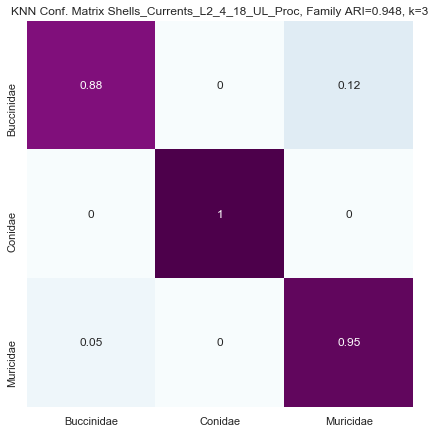

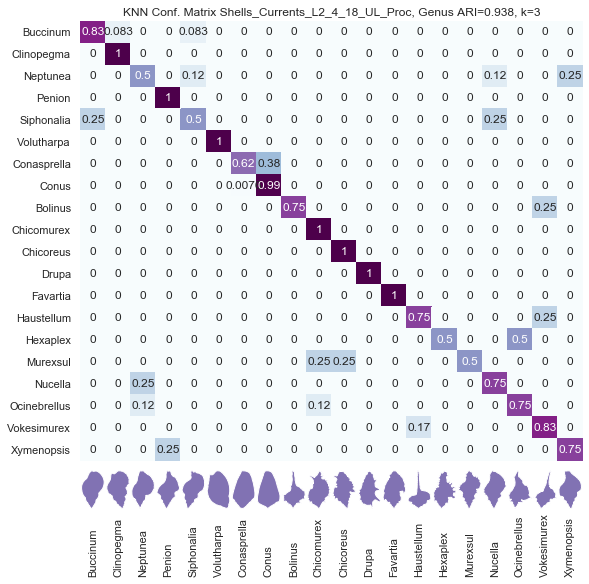

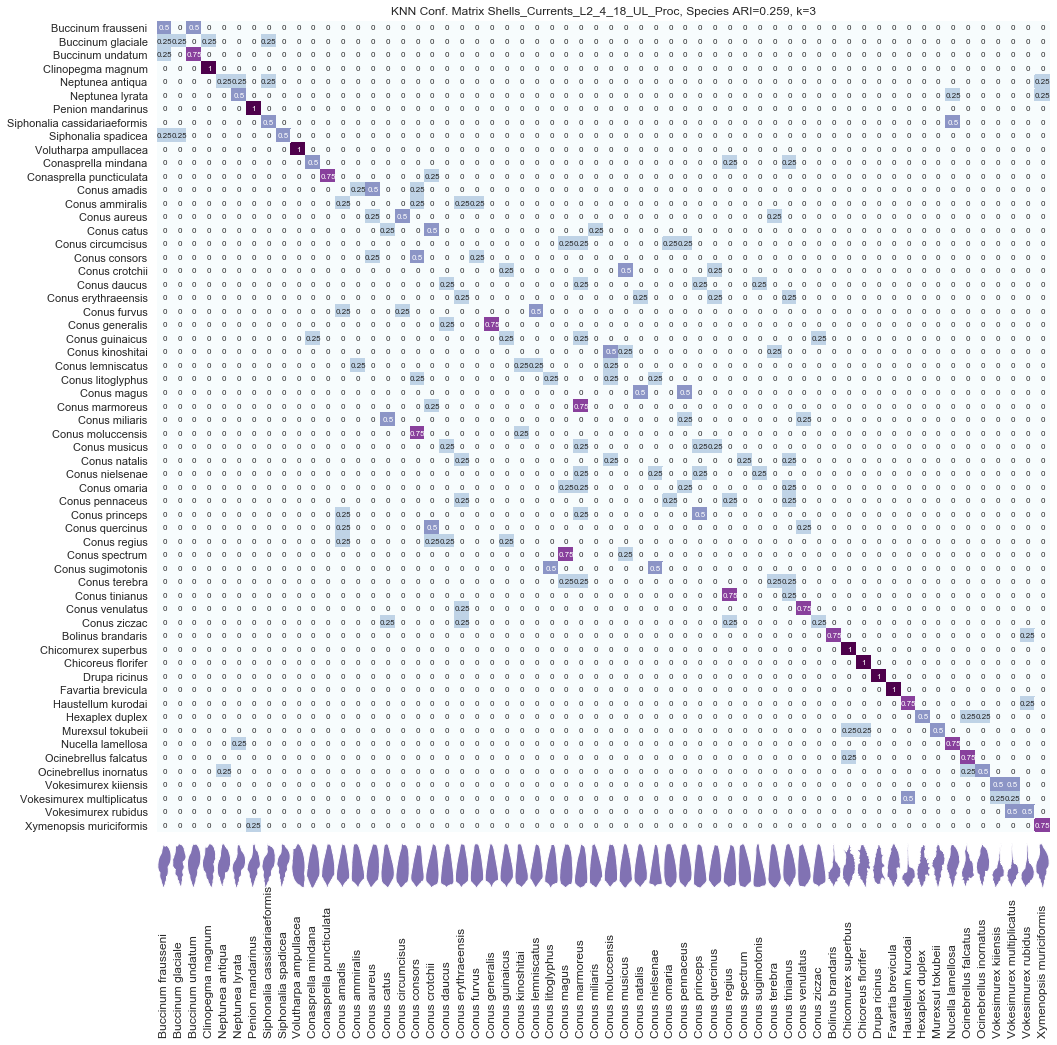

In [115]:
ind_k = np.argmax(scores_gn[1:])+1

neigh = k_neighbours[ind_k]

specie_details = {}
for shell in train_names:
    specie_details.update({shell:{"specie":list(table[table["Name"]==shell]["Sub-specie"])[0]}})

for testshell in test_names:
    dists = []
    for trainshell in train_names:
        d = all_dists[testshell][trainshell]
        dists.append(d)
    toprnk = np.argsort(dists)[:neigh]
    top_classes = []
    for ind in toprnk:
        top_classes.append(specie_details[train_names[ind]]["specie"])
    try:
        shellclass = mode(top_classes)
    except:
        shellclass = top_classes[0]

    specie_details.update({testshell:{"specie":shellclass}})

act_family = []
act_genus = []
act_specie = []

pred_family = []
pred_genus = []
pred_specie = []

for shell in test_names:
    pred_sp = int(specie_details[shell]["specie"])
    pred_gn = list(table[table["Sub-specie"]==pred_sp]["Specie"])[0]
    pred_fm = list(table[table["Sub-specie"]==pred_sp]["Genus"])[0]

    act_sp = int(list(table[table["Name"]==shell]["Sub-specie"])[0])
    act_gn = int(list(table[table["Name"]==shell]["Specie"])[0])
    act_fm = int(list(table[table["Name"]==shell]["Genus"])[0])

    act_family.append(act_fm)
    act_genus.append(act_gn)
    act_specie.append(act_sp)

    pred_family.append(pred_fm)
    pred_genus.append(pred_gn)
    pred_specie.append(pred_sp)

CM = confusion_matrix(act_family, pred_family,labels=unq_family,normalize='true')
cm_df_sc = pd.DataFrame(CM)
cm_df_sc = cm_df_sc.rename(index=dict(zip(list(cm_df_sc.index),unq_names_fm)))
cm_df_sc.columns = unq_names_fm

plt.figure(figsize=(6,6))
ax=plt.subplot(111)
plot = sns.heatmap(cm_df_sc,ax=ax,cbar=False,annot=True,cmap="BuPu")
plt.tight_layout()
ax.set_title("KNN Conf. Matrix "+title+", Family ARI="+str(np.round(scores_fm[ind_k],3))+", k="+str(neigh))
plot.figure.savefig("ConfMat_Family_"+title+"_k"+str(neigh)+".png",bbox_inches = 'tight',pad_inches=0.1)

CM = confusion_matrix(act_genus, pred_genus,labels=unq_genus,normalize='true')
cm_df_sc = pd.DataFrame(CM)
cm_df_sc = cm_df_sc.rename(index=dict(zip(list(cm_df_sc.index),unq_names_gn)))
cm_df_sc.columns = unq_names_gn

fig = plt.figure(figsize=(9,9))
gs = fig.add_gridspec(10, len(unq_genus),wspace=0.01)
ax1 = fig.add_subplot(gs[0:9, :])
ax1.set_title("KNN Conf. Matrix "+title+", Genus ARI="+str(np.round(scores_gn[ind_k],3))+", k="+str(neigh))
sns.heatmap(cm_df_sc,ax=ax1,cbar=False,annot=True,cmap="BuPu")
ax1.set_xticks([], [])
ax1.set(xlabel=' ')

mins = []
maxs = []
for i,j in enumerate(unq_genus):
    ind = list(table[table["Specie"]==j]["Index"])[0]
    y = -1*all_points[ind][1]
    mins.append(min(y))
    maxs.append(max(y))
    
for i,j in enumerate(unq_genus):
    ax = fig.add_subplot(gs[9,i])
    ind = list(table[table["Specie"]==j]["Index"])[0]
    mn = mins[i] - min(mins)
    ax.set_axis_off()
    ax.fill(all_points[ind][0],(-1*all_points[ind][1])-mn,'m')
    ax.set_title(unq_names_gn[i],rotation=90,fontsize=11,y=-1.7)
    
plot.figure.savefig("ConfMat_Genus_"+title+"_k"+str(neigh)+".png",bbox_inches = 'tight',pad_inches=0.1)


CM = confusion_matrix(act_specie, pred_specie,labels=unq_specie,normalize='true')
cm_df_sc = pd.DataFrame(CM)
cm_df_sc = cm_df_sc.rename(index=dict(zip(list(cm_df_sc.index),unq_names_sp)))
cm_df_sc.columns = unq_names_sp

fig = plt.figure(figsize=(16,16))
gs = fig.add_gridspec(15, len(unq_specie),wspace=0.01)
ax1 = fig.add_subplot(gs[0:14, :])
ax1.set_title("KNN Conf. Matrix "+title+", Species ARI="+str(np.round(scores_sp[ind_k],3))+", k="+str(neigh))
sns.heatmap(cm_df_sc,ax=ax1,cbar=False,annot=True,cmap="BuPu",annot_kws={"size": 8})
ax1.set_xticks([], [])
ax1.set(xlabel=' ')

mins = []
maxs = []
for i,j in enumerate(unq_specie):
    ind = list(table[table["Sub-specie"]==j]["Index"])[0]
    y = -1*all_points[ind][1]
    mins.append(min(y))
    maxs.append(max(y))
    
for i,j in enumerate(unq_specie):
    ax = fig.add_subplot(gs[14,i])
    ind = list(table[table["Sub-specie"]==j]["Index"])[0]
    mn = mins[i] - min(mins)
    ax.set_axis_off()
    ax.fill(all_points[ind][0],(-1*all_points[ind][1])-mn,'m')
    ax.set_title(unq_names_sp[i],rotation=90,y=-3.1)

plot.figure.savefig("ConfMat_Specie_"+title+"_k"+str(neigh)+".png",bbox_inches = 'tight',pad_inches=0.1)



### K Comparisons

In [122]:
df = pd.DataFrame([k_neighbours,scores_fm,scores_gn,scores_sp]).T
df = df.rename(columns={0:"Neighbours",1:"Family",2:"Genus",3:"Specie"})
df2 = df.melt("Neighbours", var_name='Rank',  value_name='ARI')
ARI = list(df2.sort_values(by=['Neighbours',"Rank"])["ARI"])

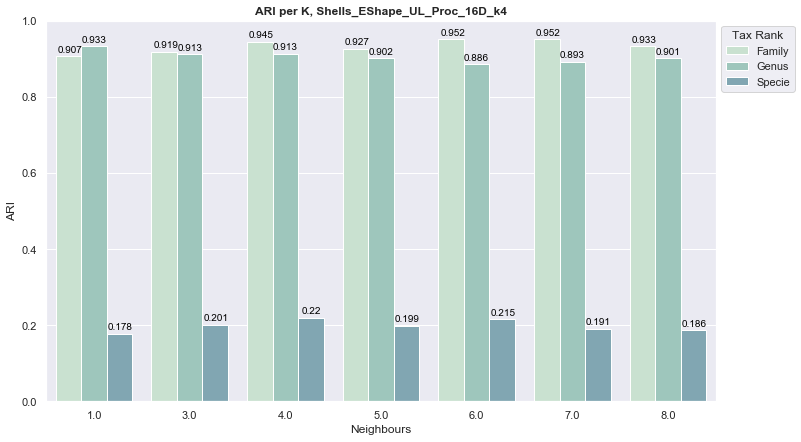

In [123]:
fig_dims = (12, 7)
fig, ax = plt.subplots(figsize=fig_dims)
axis = [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6]
g = sns.barplot(x="Neighbours", y="ARI", hue='Rank', data=df2,palette = sns.cubehelix_palette(7, start=.95, rot=-.75)
           ,ax = ax)
for i in range(0,len(ARI)):
    p = 0
    if i%3 == 0:
        p = -0.25
    if i%3 == 2:
        p = 0.275
        
    g.text(axis[i]+p,ARI[i]+0.01,str(np.round(ARI[i],3)), color='black', ha="center",fontsize=10)

ax.legend(title="Tax Rank",bbox_to_anchor=(1, 1))
ax.set_ylim([0,1])
ax.set_title("ARI per K, "+title,fontweight='bold')
plt.savefig(title+"_Kcomp.png",bbox_inches = 'tight',pad_inches=0.1)

### E-shape Dimension Comparisons

In [42]:
scores_fm_47 = deepcopy(scores_fm)
scores_gn_47 = deepcopy(scores_gn)
scores_sp_47 = deepcopy(scores_sp)

In [47]:
scores_fm_31 = deepcopy(scores_fm)
scores_gn_31 = deepcopy(scores_gn)
scores_sp_31 = deepcopy(scores_sp)

In [37]:
scores_fm_16 = deepcopy(scores_fm)
scores_gn_16 = deepcopy(scores_gn)
scores_sp_16 = deepcopy(scores_sp)

In [88]:
df_fm = pd.DataFrame([k_neighbours,scores_fm_47,scores_fm_31,scores_fm_16]).T
df_fm = df_fm.rename(columns={0: "Neighbours", 1: "47D - 99%", 2: "31D - 98%", 3: "16D - 95%"})
df_fm = df_fm.melt("Neighbours", var_name='Dimension',  value_name='ARI')

In [89]:
df_gn = pd.DataFrame([k_neighbours,scores_gn_47,scores_gn_31,scores_gn_16]).T
df_gn = df_gn.rename(columns={0: "Neighbours", 1: "47D - 99%", 2: "31D - 98%", 3: "16D - 95%"})
df_gn = df_gn.melt("Neighbours", var_name='Dimension',  value_name='ARI')

In [90]:
df_sp = pd.DataFrame([k_neighbours,scores_sp_47,scores_sp_31,scores_sp_16]).T
df_sp = df_sp.rename(columns={0: "Neighbours", 1: "47D - 99%", 2: "31D - 98%", 3: "16D - 95%"})
df_sp = df_sp.melt("Neighbours", var_name='Dimension',  value_name='ARI')

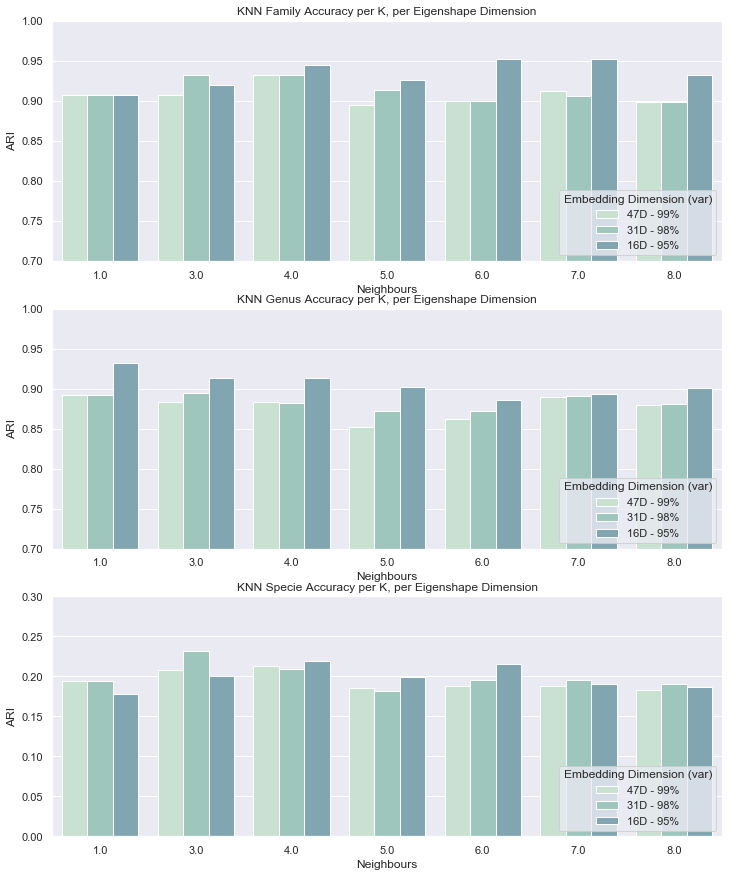

In [116]:
fig_dims = (12, 15)
fig, ax = plt.subplots(3,1,figsize=fig_dims)
sns.barplot(x="Neighbours", y="ARI", hue='Dimension', data=df_fm,palette = sns.cubehelix_palette(7, start=.95, rot=-.75)
           ,ax = ax[0])

ax[0].set_ylim([0.7,1])
ax[0].set_title("KNN Family Accuracy per K, per Eigenshape Dimension")
ax[0].legend(title='Embedding Dimension (var)',loc="lower right")
sns.barplot(x="Neighbours", y="ARI", hue='Dimension', data=df_gn,palette = sns.cubehelix_palette(7, start=.95, rot=-.75)
           ,ax = ax[1])

ax[1].set_ylim([0.7,1])
ax[1].set_title("KNN Genus Accuracy per K, per Eigenshape Dimension")
ax[1].legend(title='Embedding Dimension (var)',loc="lower right")

sns.barplot(x="Neighbours", y="ARI", hue='Dimension', data=df_sp,palette = sns.cubehelix_palette(7, start=.95, rot=-.75)
           ,ax = ax[2])

ax[2].set_ylim([0,0.3])
ax[2].set_title("KNN Specie Accuracy per K, per Eigenshape Dimension")
ax[2].legend(title='Embedding Dimension (var)',loc="lower right")

fig.savefig("KNN_ARI_Eigenshape_Dimension_Comparison_Shells.png",bbox_inches = 'tight')
